In [1]:
# Data is from https://empowerprogram.hhs.gov/about-empowermap.html

In [2]:
import pandas as pd

In [3]:
# Import excel files of empower DME users

years = [2016, 2017, 2018, 2019, 2020, 2021]

dataframes = [pd.ExcelFile(str(year)+"_HHSemPOWERMapHistoricalDataset.xlsx").parse("Zip Code") for year in years]

In [4]:
# import nyc zip codes and population

nyc_zip = pd.read_csv('/Users/minjukim/Documents/codes/Reporting2/df_nyc_zip.csv')

In [5]:
nyc_dfs = [dataframe.merge(nyc_zip, how="right", left_on='Zip_Code', right_on = 'Zipcode') for dataframe in dataframes]


In [6]:
for i, df in enumerate(nyc_dfs):
    nyc_dfs[i] = df.drop(["Zipcode", "Unnamed: 0"], axis=1)
    for month in range(1, 13):
        nyc_dfs[i][month] = df[df.columns[month*2+5]]/df[df.columns[month*2+4]]*100

In [7]:
years=[]
for i, df in enumerate(nyc_dfs):
    dme_pop = {}
    for month in range(1, 13):
        dme_pop[month] = nyc_dfs[i][month].mean()
    years.append(dme_pop)

In [8]:
monthly_df = pd.DataFrame(years).transpose()
monthly_df.columns = monthly_df.columns+2016
monthly_df.reset_index(inplace=True, names="month")

In [9]:
monthly_df.month = monthly_df.month.astype(str).str.zfill(2)

In [11]:
melted_monthly = pd.melt(monthly_df, id_vars='month', var_name="year", value_name='pct_DME_users')

In [12]:
melted_monthly['date'] = melted_monthly.year.astype(str) + "-" + melted_monthly.month.astype(str)

In [14]:
melted_monthly.date = pd.to_datetime(melted_monthly.date, format="%Y-%m")

In [15]:
# Get zip code data on most recent data available.
df_2022 = pd.ExcelFile("2022_HHSemPOWERMapHistoricalDataset.xlsx").parse("Zip Code")

In [16]:
df_2022['August'] = df_2022['Aug_2022_Power_Dependent_Devices_DME']/df_2022["Aug_2022_Medicare_Benes"]*100

In [17]:
df_2022 = df_2022.merge(nyc_zip, how="inner", left_on='Zip_Code', right_on = 'Zipcode')

In [18]:
df_2022 = df_2022[df_2022.County!="Nassau "]

## Comparing oldest and newest datapoint.

In [21]:
nyc_dfs[0]["Jan_2016_Medicare_Benes"].sum()

1094567.0

In [22]:
nyc_dfs[0]["Jan_2016_Power_Dependent_Devices_DME"].sum()

25226.0

In [23]:
df_2022["Aug_2022_Medicare_Benes"].sum()


1338990

In [24]:
df_2022["Aug_2022_Power_Dependent_Devices_DME"].sum()

35703

In [25]:
df_2022.August.mean()

3.7922225819773474

## Cross referencing DME dependency with household income

In [26]:
income_df = pd.read_csv("acs2020_5yr_B19013_86000US10460/acs2020_5yr_B19013_86000US10460.csv")

In [29]:
# Rename and simplify columns

income_df = income_df.rename({"name": "Zip_Code", "B19013001": "median_household_income"}, axis="columns")

In [30]:
dme_income_df = pd.merge(df_2022, income_df)

In [31]:
# Exclude zip codes where poluation is 0 or close to 0

dme_income_df = dme_income_df[(dme_income_df.Estimate!=0) & (dme_income_df.median_household_income.notnull())]

In [32]:
# dme_income_df.to_csv('dme_income.csv')

Text(0, 0.5, 'Pct of electric medical equipment users')

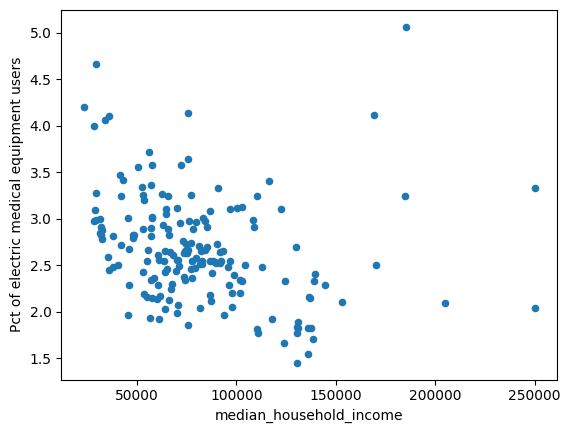

In [33]:
ax = dme_income_df.plot(x="median_household_income", y="August", kind="scatter")
ax.set_ylabel("Pct of electric medical equipment users")

In [34]:
dme_income_df.plot

In [35]:
income_df.geoid = income_df.geoid[-5:]

# Factor in age to the existing plot

In [76]:
import json

age_df = pd.read_csv("acs2020_5yr_B01001_86000US10460/acs2020_5yr_B01001_86000US10460.csv")

with open("acs2020_5yr_B01001_86000US10460/metadata.json") as f:
    metadata = json.load(f)

In [77]:
name_of_cols = {k:v["name"] for k, v in metadata["tables"]["B01001"]["columns"].items()}

In [78]:
age_df.rename(columns=name_of_cols, inplace=True)

In [79]:
melted_age = age_df.melt(id_vars=['geoid', 'name'])

In [80]:
pd.options.display.max_columns=None

pivoted_age = melted_age.pivot_table(index=["name", "geoid"], columns="variable", values="value", aggfunc="sum").reset_index()


In [81]:
# Remove margin of error columns
pivoted_age.drop(list(pivoted_age.filter(regex = 'Error')), axis = 1, inplace = True)

In [113]:
pct_dict = {}

for col in pivoted_age.columns[4:-5]:
    pct_dict[col] = pivoted_age[col] / pivoted_age["Total:"]*100

In [114]:
pct_df = pd.DataFrame(pct_dict)

,18 and 19 years,20 years,21 years,22 to 24 years,25 to 29 years,30 to 34 years,35 to 39 years,40 to 44 years,45 to 49 years,5 to 9 years,50 to 54 years,55 to 59 years,60 and 61 years,62 to 64 years,65 and 66 years,67 to 69 years,70 to 74 years,75 to 79 years,80 to 84 years
0,3.320547,1.026932,1.506433,5.050747,12.610885,13.813634,8.247423,7.532167,6.625110,2.665228,6.181571,4.431391,2.924958,3.108767,1.402541,1.530408,2.745145,2.944937,1.554383
1,1.472506,0.859298,1.453680,3.863480,9.506072,7.999946,5.945161,6.070223,6.437341,4.065194,5.856407,6.998104,3.314821,3.398195,3.079488,3.651009,5.175961,3.378024,3.910547
2,11.940517,3.345467,2.050447,5.229464,14.790291,13.411132,6.423881,4.942291,3.361929,1.498052,4.872784,4.618536,1.677306,3.495455,1.605970,2.813192,2.846116,2.601013,1.300507
3,2.447130,0.181269,0.090634,2.326284,21.903323,9.244713,8.157100,4.803625,6.283988,1.601208,12.567976,7.915408,2.024169,6.283988,3.655589,1.238671,1.570997,0.876133,0.000000
4,0.854109,1.685134,1.211911,8.737304,25.657895,17.036011,9.626039,9.533703,4.789935,2.262235,4.593721,3.901200,1.096491,0.011542,0.000000,0.196214,0.588643,0.277008,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,2.760978,1.880095,1.136530,3.516230,7.761416,6.198323,5.906156,4.280247,5.930990,9.217869,5.666579,6.372162,2.264294,2.498028,2.430829,2.294972,2.781430,1.887399,1.799749
209,2.076449,1.594177,0.397428,3.174958,5.711351,5.488077,8.319193,7.019737,6.689292,7.421631,5.296061,6.675895,1.473609,4.402965,1.960347,2.750737,3.429490,2.232741,2.085380
210,1.604114,1.174303,0.813570,2.962622,7.644485,5.426357,6.592985,4.612787,5.457057,7.045821,7.828690,7.337478,3.315680,5.971295,1.834369,2.502111,4.397882,3.584312,1.941822
211,1.448866,1.199548,0.329288,3.292878,4.078465,6.134161,7.258444,4.468906,6.712767,4.642958,9.055414,10.057390,2.126258,4.544172,2.380280,3.829147,4.435977,2.784834,2.507291


In [115]:
pct_df = pd.concat([pct_df, pd.DataFrame(pivoted_age.name)], axis=1)

In [117]:
cols = pct_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
pct_df = pct_df[cols]

pct_df.to_csv("age_pct_by_zip.csv")